In [4]:
# importing the libraries
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [5]:
# version of pytorch
print(torch.__version__)

1.3.1


In [7]:
# transformations to be applied on images
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [ ]:
## Now, let’s load the training and testing set of the MNIST dataset:

In [8]:
# defining the training and testing set
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
testset = datasets.MNIST('./', download=True, train=False, transform=transform)

0it [00:00, ?it/s]

9920512it [00:03, 2600261.90it/s]                                                                             


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


0it [00:00, ?it/s]

32768it [00:00, 35280.96it/s]                                                                                 
0it [00:00, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


1654784it [00:02, 713469.96it/s]                                                                              
0it [00:00, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


8192it [00:00, 11923.13it/s]                                                                                  


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...
Done!


0it [00:00, ?it/s]

9920512it [00:12, 1047958.09it/s]                                                                             

Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



0it [00:00, ?it/s]


32768it [00:00, 35995.69it/s]                                                                                 

0it [00:00, ?it/s]

Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



1654784it [00:02, 703034.84it/s]                                                                              

0it [00:00, ?it/s]

Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



8192it [00:00, 11880.42it/s]                                                                                  


Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw
Processing...
Done!


In [9]:
# Next, I have defined the train and test loader which will help us to load the training and test set in batches. I will define the batch size as 64:

# defining trainloader and testloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

9920512it [00:29, 1047958.09it/s]

In [10]:
# shape of training data
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


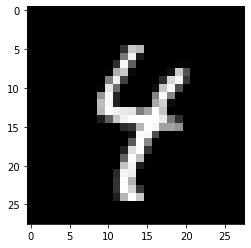

In [11]:
# So, in each batch, we have 64 images, each of size 28,28 and for each image, we have a corresponding label. Let’s visualize a training image and see how it looks:

# visualizing the training images
plt.imshow(images[0].numpy().squeeze(), cmap='gray')

In [12]:
#It’s an image of number 0. Similarly, let’s visualize the test set image:

# shape of validation data
dataiter = iter(testloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [13]:
# Defining Model Architecture
# We will be using a CNN model here. So let us define and train this model:

# defining the model architecture
class Net(nn.Module):   
  def __init__(self):
      super(Net, self).__init__()

      self.cnn_layers = nn.Sequential(
          # Defining a 2D convolution layer
          nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          # Defining another 2D convolution layer
          nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
      )

      self.linear_layers = nn.Sequential(
          nn.Linear(4 * 7 * 7, 10)
      )

  # Defining the forward pass    
  def forward(self, x):
      x = self.cnn_layers(x)
      x = x.view(x.size(0), -1)
      x = self.linear_layers(x)
      return x

In [ ]:
#Let’s also define the optimizer and loss function then we will look at the summary of this model:

In [14]:
# defining the model
model = Net()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


So, we have 2 convolutional layers that will help to extract features from the images. Features from these convolutional layers are passed to the fully connected layer which classifies the images into their respective class. Now our model architecture is ready, let’s train this model for 10 epochs:

In [15]:
for i in range(10):
    running_loss = 0
    for images, labels in trainloader:

        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()

        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))

Epoch 1 - Training loss: 0.16605456616046396
Epoch 2 - Training loss: 0.09048631871148928
Epoch 3 - Training loss: 0.07914899759141526
Epoch 4 - Training loss: 0.07150491072596717
Epoch 5 - Training loss: 0.06794889853261452
Epoch 6 - Training loss: 0.06573310087049958
Epoch 7 - Training loss: 0.06363410825184834
Epoch 8 - Training loss: 0.061638841598502185
Epoch 9 - Training loss: 0.05831823686533955
Epoch 10 - Training loss: 0.05911459443050184


You can see that the training is decreasing with an increasing number of epochs. This means that our model is learning patterns from the training set. Let’s check the performance of this model on the test set:

In [17]:
# getting predictions on test set and measuring the performance
correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    img = images[i].view(1, 1, 28, 28)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9629


## Implementing a CNN in TensorFlow

In [16]:
# importing the libraries
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

C:\Users\bsram\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\bsram\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\bsram\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\bsram\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [18]:
# version of tensorflow
print(tf.__version__)

1.14.0


In [19]:
# we are using the 2.2.0 version of TensorFlow. Let’s now load the MNIST dataset using the datasets class of tensorflow.keras:

(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data(path='mnist.npz')
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

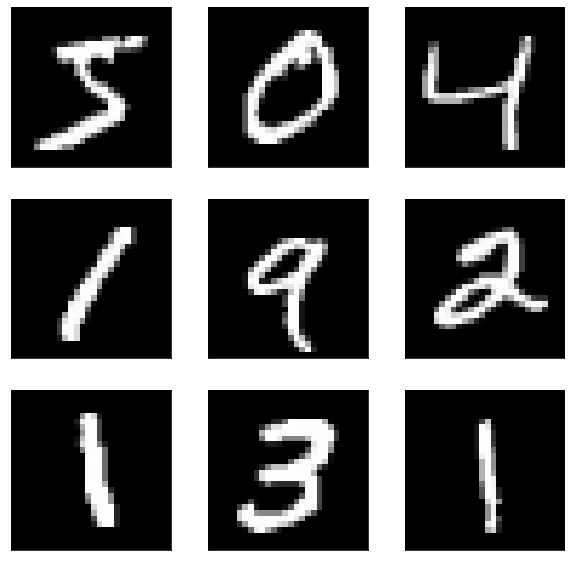

In [20]:
# visualizing a few images
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
plt.show()

In [21]:
# shape of the training and test set
(train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape)

(((60000, 28, 28), (60000,)), ((10000, 28, 28), (10000,)))

In [22]:
# reshaping the images
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# one hot encoding the target variable
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

## Defining Model Architecture
Now, we will define the architecture of our model. We will use the same architecture which we defined in PyTorch. So, our model will have 2 convolutional layers, with a combination of max-pooling layers, then we will have a flatten layer and finally a dense layer with 10 neurons since we have 10 classes.


In [23]:

# defining the model architecture
model = models.Sequential()
model.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(4, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [24]:
#Let’s quickly look at the summary of the model:

# summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 4)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 4)         148       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 4)           0         
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
Total params: 1,198
Trainable params: 1,198
Non-trainable params: 0
______________________________________________________

In [25]:
# compiling the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
# training the model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 37s 609us/sample - loss: 0.4676 - acc: 0.8541 - val_loss: 0.1976 - val_acc: 0.9392
Epoch 2/10
60000/60000 [==============================] - 38s 635us/sample - loss: 0.1935 - acc: 0.9407 - val_loss: 0.1478 - val_acc: 0.9548
Epoch 3/10
60000/60000 [==============================] - 32s 538us/sample - loss: 0.1530 - acc: 0.9531 - val_loss: 0.1185 - val_acc: 0.9629
Epoch 4/10
60000/60000 [==============================] - 39s 657us/sample - loss: 0.1317 - acc: 0.9600 - val_loss: 0.1031 - val_acc: 0.9685 0
Epoch 5/10
60000/60000 [==============================] - 45s 746us/sample - loss: 0.1195 - acc: 0.9630 - val_loss: 0.0981 - val_acc: 0.9688
Epoch 6/10
60000/60000 [==============================] - 41s 678us/sample - loss: 0.1105 - acc: 0.9657 - val_loss: 0.0928 - val_acc: 0.9714
Epoch 7/10
60000/60000 [==============================] - 41s 677us/sample - loss: 0.1050 - acc: 0.968

To summarize, initially, the training loss was about 0.46 and after 10 epochs, the training loss reduced to 0.08. The training and validation accuracies after 10 epochs are 97.31% and 97.48% respectively.

## Notes
To summarize,we first looked at a brief overview of PyTorch and TensorFlow. Then we understood the MNIST handwritten digit classification challenge and finally, build an image classification model using CNN(Convolutional Neural Network) in PyTorch and TensorFlow. Now, I hope you will be familiar with both these frameworks. 